## Google Colab things. Feel free to ignore

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [1]:
!pip install nba_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 5.1 MB/s eta 0:00:00


## Libraries

In [332]:
from nba_api.stats.library import parameters
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.endpoints import leaguegamefinder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
#from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import r2_score, mean_absolute_error

In [333]:
#Strictly for me. This can be ignored
pd.set_option('display.max_columns',None)

## Building the DataSet

In [334]:

# Initialize an empty DataFrame to store all data
all_seasons_df = pd.DataFrame()

# Loop through seasons from 2003-04 to 2020-21
for year in range(2003, 2024):
    season = f"{year}-{str(year+1)[-2:]}"
    params = {'measure_type_detailed_defense': 'Advanced',}
    # Fetch data for the season
    team_stats = leaguedashteamstats.LeagueDashTeamStats(season=season, per_mode_detailed='PerGame',**params)
    season_df = team_stats.get_data_frames()[0]

    # Add a column for the season
    season_df['SEASON'] = year+1

    all_seasons_df = pd.concat([all_seasons_df, season_df], ignore_index=True)


In [335]:
all_seasons_df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,OFF_RATING_RANK,DEF_RATING_RANK,NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,SEASON
0,1610612737,Atlanta Hawks,82,28,54,0.341,3981.0,98.2,99.1,103.1,103.9,-4.9,-4.8,0.583,1.22,15.7,0.308,0.686,0.500,0.176,0.465,0.514,93.5,92.68,77.24,7680,0.466,1,25,25,25,4,24,24,26,24,27,24,19,13,17,24,18,17,10,25,2004
1,1610612738,Boston Celtics,82,36,46,0.439,3941.0,99.9,100.7,100.2,102.2,-0.3,-1.5,0.592,1.26,16.1,0.279,0.658,0.473,0.172,0.486,0.532,95.8,94.47,78.73,7757,0.490,1,20,20,20,28,16,17,19,18,23,21,28,26,28,23,5,4,3,19,2004
2,1610612741,Chicago Bulls,82,23,59,0.280,3966.0,93.9,95.6,100.5,102.1,-6.6,-6.5,0.641,1.36,16.7,0.311,0.679,0.491,0.172,0.446,0.486,94.8,93.23,77.69,7694,0.446,1,28,28,28,11,28,16,28,6,19,12,17,18,22,22,29,29,8,27,2004
3,1610612739,Cleveland Cavaliers,82,35,47,0.427,3971.0,98.4,100.6,101.3,103.1,-2.9,-2.6,0.619,1.49,16.9,0.340,0.688,0.514,0.160,0.451,0.498,93.6,91.71,76.43,7577,0.491,1,21,21,21,7,18,20,21,12,10,11,4,12,5,11,28,27,14,18,2004
4,1610612742,Dallas Mavericks,82,52,30,0.634,3961.0,109.6,110.4,104.3,105.9,5.3,4.5,0.591,1.96,17.7,0.335,0.686,0.507,0.128,0.495,0.536,95.7,94.62,78.85,7814,0.527,1,7,7,7,15,1,26,6,19,1,6,6,14,10,1,3,3,2,8,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,1610612758,Sacramento Kings,20,12,8,0.600,970.0,112.5,114.5,113.2,114.8,-0.7,-0.3,0.652,2.00,19.1,0.272,0.742,0.496,0.134,0.545,0.577,102.2,100.60,83.84,2033,0.484,27,11,7,10,27,12,20,19,5,7,7,22,2,18,12,10,15,10,22,2024
625,1610612759,San Antonio Spurs,21,3,18,0.143,1018.0,105.1,107.1,116.8,118.9,-11.7,-11.8,0.703,1.80,20.0,0.269,0.711,0.483,0.157,0.526,0.557,104.2,102.27,85.23,2170,0.452,14,28,28,28,15,27,27,30,1,17,3,24,16,25,27,23,24,4,28,2024
626,1610612761,Toronto Raptors,22,9,13,0.409,1066.0,108.9,111.3,110.5,113.1,-1.5,-1.8,0.674,1.98,19.7,0.313,0.722,0.513,0.144,0.524,0.553,101.1,98.81,82.35,2195,0.496,5,21,22,22,7,23,14,22,3,8,4,8,11,9,19,25,26,22,20,2024
627,1610612762,Utah Jazz,22,7,15,0.318,1071.0,107.2,109.4,116.4,118.0,-9.2,-8.6,0.651,1.48,18.1,0.341,0.720,0.526,0.174,0.518,0.556,101.7,100.01,83.34,2231,0.455,5,24,25,25,5,26,25,27,6,29,20,2,13,2,30,26,25,14,27,2024


In [336]:

# Initialize an empty DataFrame to store win counts
playoff_wins = pd.DataFrame()

# Loop through each season
for year in range(2003, 2024):
    season = f"{year}-{str(year+1)[-2:]}"

    # Fetch game data
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=season, season_type_nullable='Playoffs')
    games_df = gamefinder.get_data_frames()[0]

    # Filter for wins and count them
    wins_df = games_df[games_df['WL'] == 'W'].groupby('TEAM_NAME').size().reset_index(name='PLAYOFF_WINS')
    wins_df['SEASON'] = year+1

    playoff_wins = pd.concat([playoff_wins, wins_df], ignore_index=True)


In [337]:
merged_df = pd.merge(all_seasons_df, playoff_wins, how='left', on=['TEAM_NAME', 'SEASON'])
merged_df['PLAYOFF_WINS'] = merged_df['PLAYOFF_WINS'].fillna(0)
merged_df

## Visualizations

In [340]:
features = ['W', 'L', 'W_RANK','W_PCT', 'MIN','OFF_RATING', 'DEF_RATING','NET_RATING','NET_RATING_RANK', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT','E_PACE', 'PACE', 'POSS', 'PIE','PIE_RANK']

target = 'PLAYOFF_WINS'

cor_mat_features = ['W', 'L','W_RANK', 'W_PCT', 'MIN','OFF_RATING', 'DEF_RATING','NET_RATING','NET_RATING_RANK', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE','PACE_PER40', 'POSS', 'PIE','PIE_RANK','PLAYOFF_WINS']

In [385]:
palette = sns.color_palette("hls", n_colors=30)

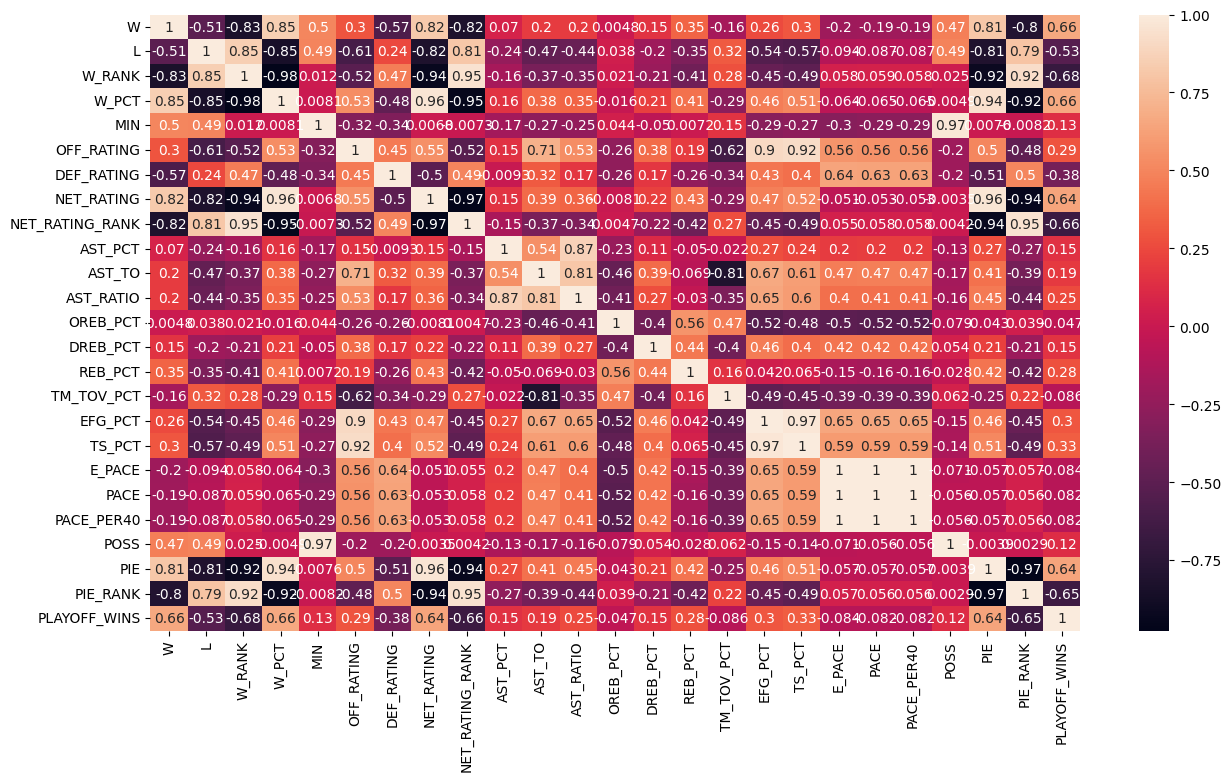

In [342]:
fig, ax = plt.subplots(figsize=(15, 8))  # Size is in inches (width, height)

cor_mat = merged_df[cor_mat_features].corr()
sns.heatmap(cor_mat, annot=True,ax = ax)
plt.show()

<ipython-input-386-af8669047d41>:3: UserWarning: 
The palette list has fewer values (30) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=merged_df, x='W_PCT', y='PLAYOFF_WINS', hue='TEAM_NAME', palette=palette)


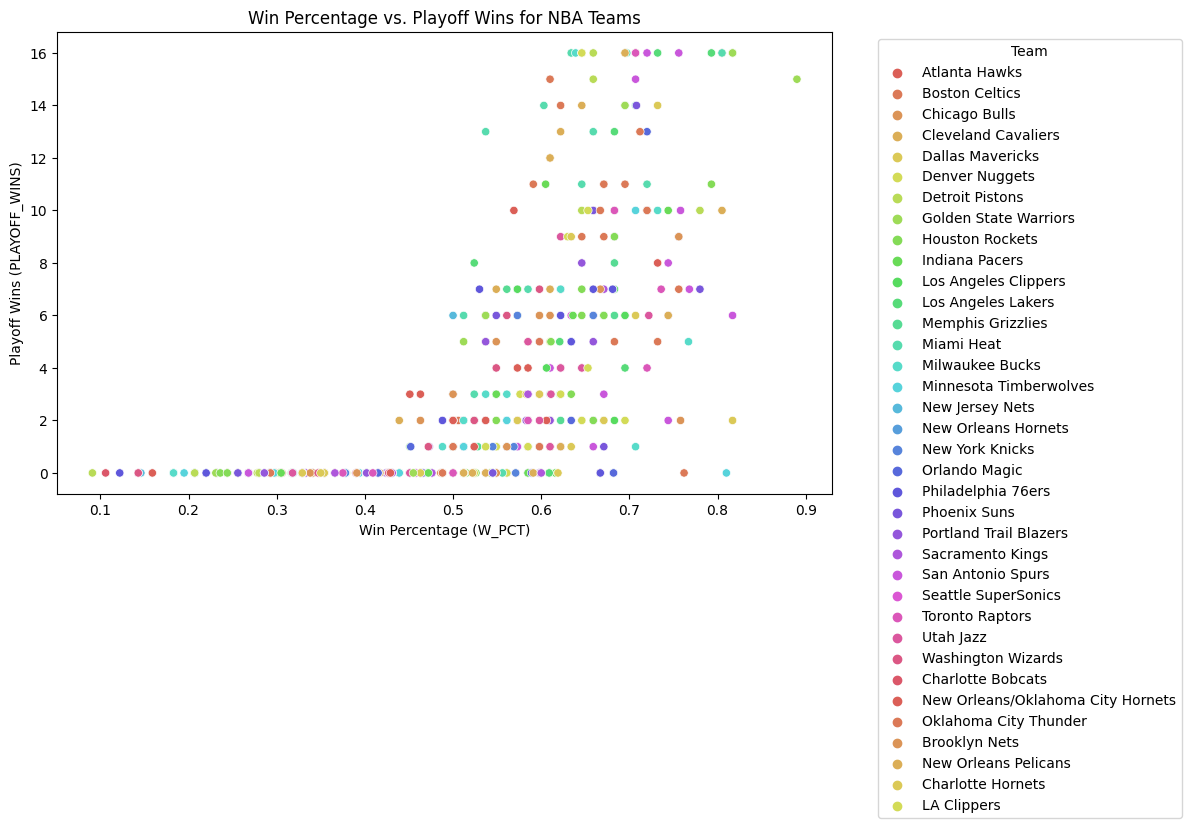

In [386]:
# Create a scatter plot of Win Percentage vs. Playoff Wins
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='W_PCT', y='PLAYOFF_WINS', hue='TEAM_NAME', palette=palette)
plt.title('Win Percentage vs. Playoff Wins for NBA Teams')
plt.xlabel('Win Percentage (W_PCT)')
plt.ylabel('Playoff Wins (PLAYOFF_WINS)')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<ipython-input-398-da902e3c2aac>:3: UserWarning: 
The palette list has fewer values (30) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=merged_df, x='PIE', y='PLAYOFF_WINS', hue='TEAM_NAME', palette=palette)


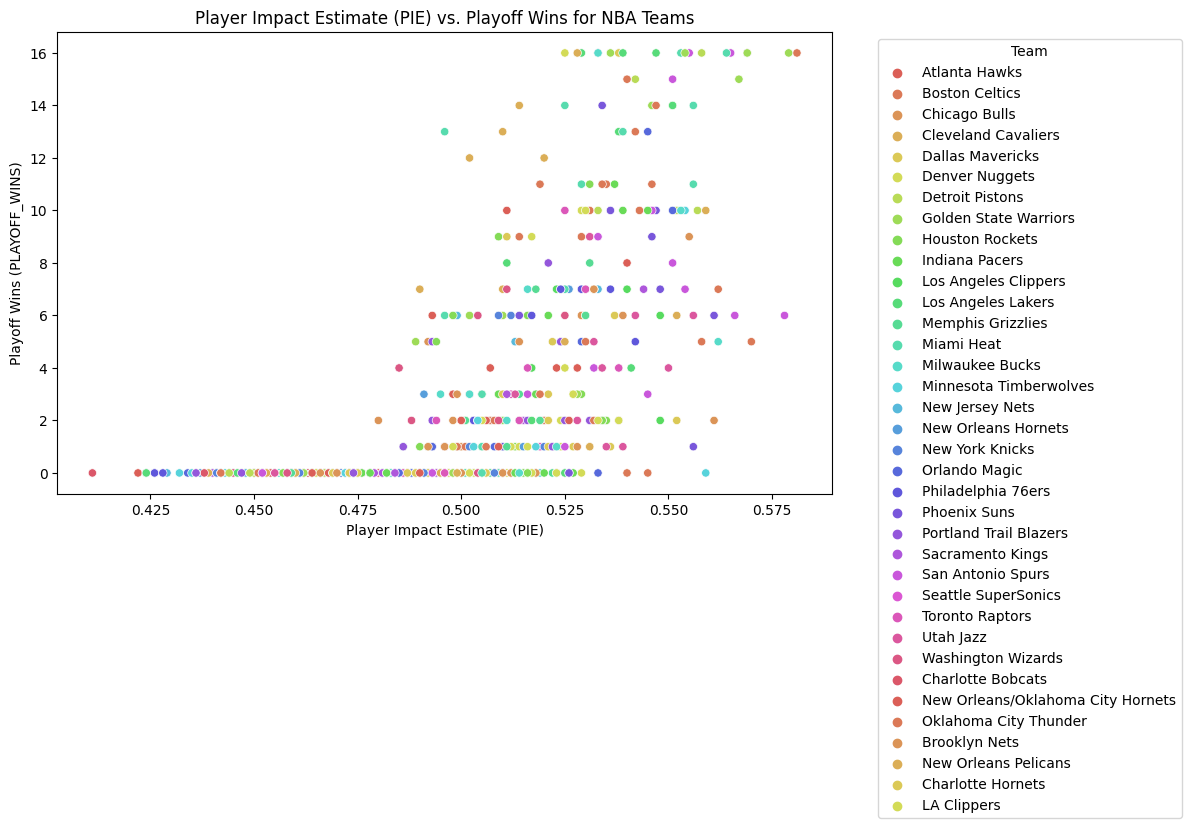

In [398]:
# Create a scatter plot of PIE (Player Impact Estimate) vs. Playoff Wins
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='PIE', y='PLAYOFF_WINS', hue='TEAM_NAME', palette=palette)
plt.title('Player Impact Estimate (PIE) vs. Playoff Wins for NBA Teams')
plt.xlabel('Player Impact Estimate (PIE)')
plt.ylabel('Playoff Wins (PLAYOFF_WINS)')
plt.legend(title='Team',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<ipython-input-388-5227078d8aff>:3: UserWarning: 
The palette list has fewer values (30) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=merged_df, x='NET_RATING', y='PLAYOFF_WINS', hue='TEAM_NAME', palette=palette)


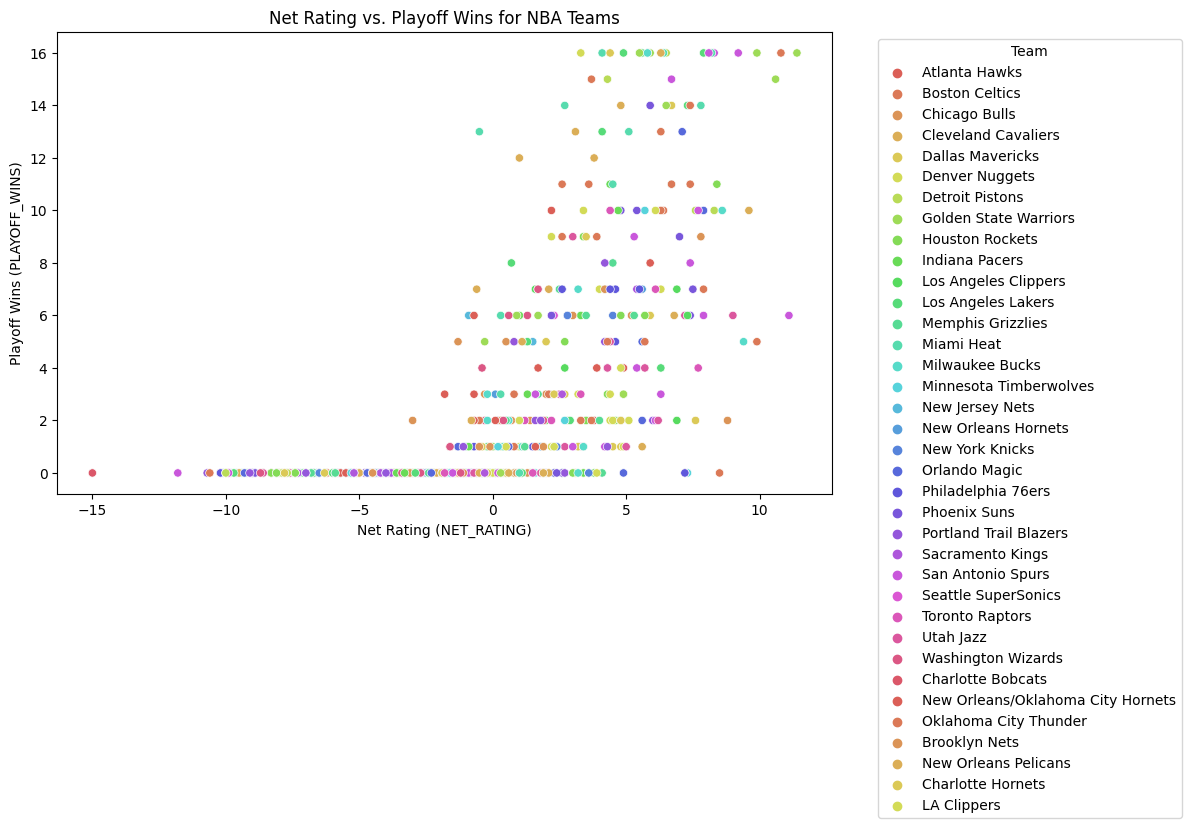

In [388]:
# Create a scatter plot of Net Rating vs. Playoff Wins
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='NET_RATING', y='PLAYOFF_WINS', hue='TEAM_NAME', palette=palette)
plt.title('Net Rating vs. Playoff Wins for NBA Teams')
plt.xlabel('Net Rating (NET_RATING)')
plt.ylabel('Playoff Wins (PLAYOFF_WINS)')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<ipython-input-389-b24b928fcb3b>:2: UserWarning: 
The palette list has fewer values (30) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=merged_df, x='SEASON', y='NET_RATING', hue='TEAM_NAME', palette=palette, s=50)


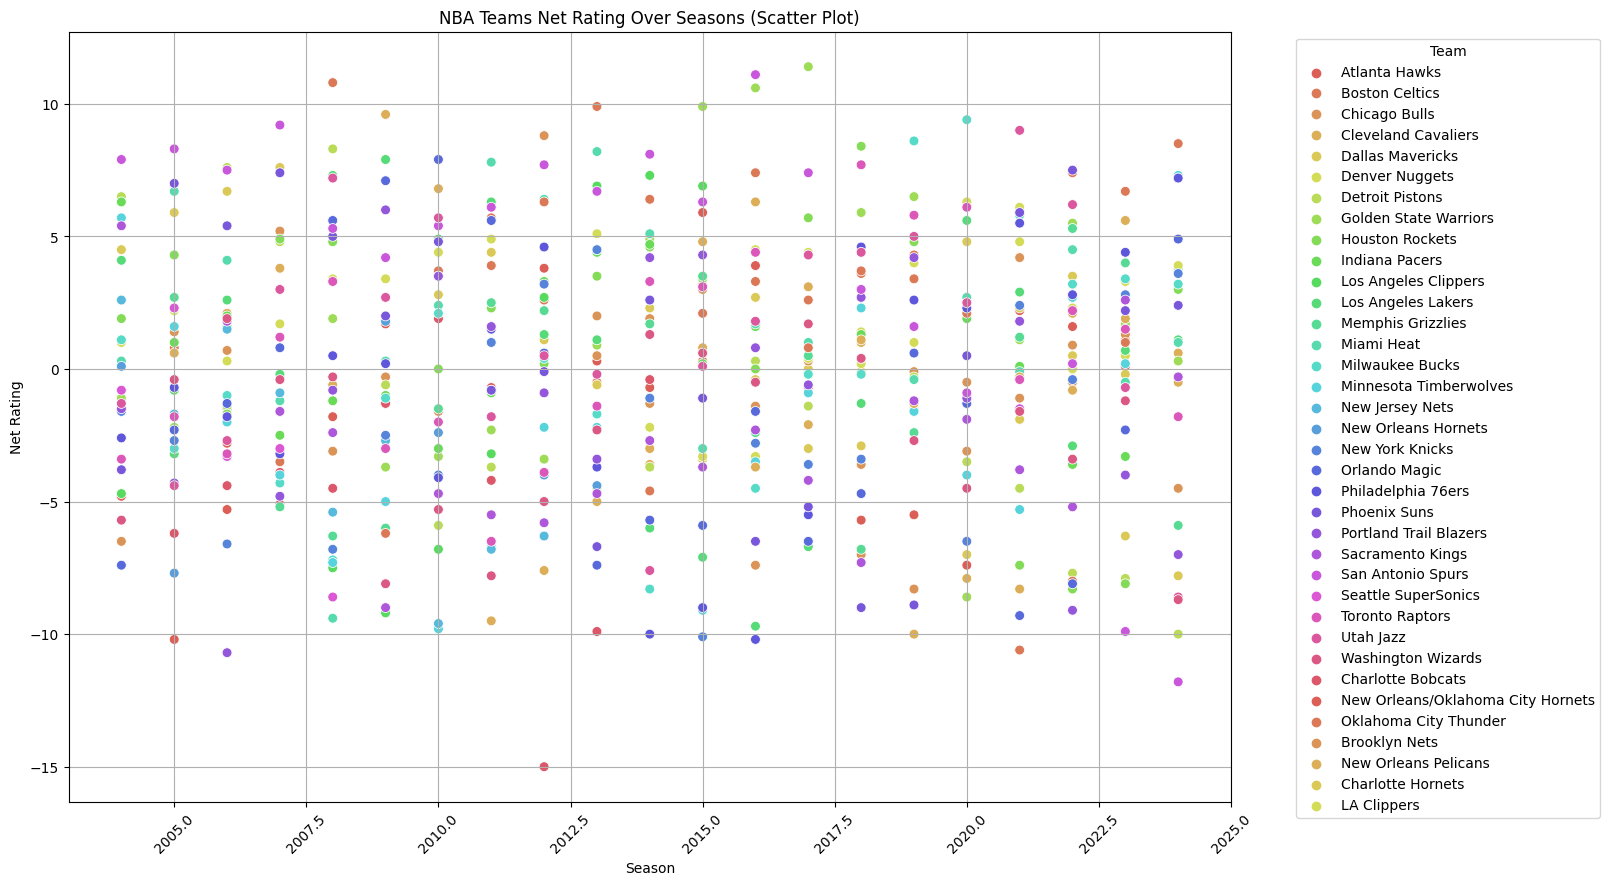

In [389]:
#Visualizing Net Rating over the years
plt.figure(figsize=(15, 10))
sns.scatterplot(data=merged_df, x='SEASON', y='NET_RATING', hue='TEAM_NAME', palette=palette, s=50)
plt.title('NBA Teams Net Rating Over Seasons (Scatter Plot)')
plt.xlabel('Season')
plt.ylabel('Net Rating')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Building the ML Models

In [347]:
X=merged_df.loc[merged_df['SEASON']<2011]
y=X[target].to_numpy()
X= X[features]

In [348]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [349]:
split = KFold(n_splits=5)

## Random Forest Regressor

In [ ]:
#Using K-Fold cross validation to determine the best metrics for the best possible model
for i in range(50,301,10):
  for j in range(10,51,10):
    scores=[]
    for train_index, val_index in split.split(X_train):
        X_subtrain = X_train.iloc[train_index]
        X_val = X_train.iloc[val_index]
        y_subtrain = y_train[train_index]
        y_val = y_train[val_index]
        mod = RandomForestRegressor(n_estimators=i,max_depth=j, min_samples_split = 2,max_features=4,random_state = 42,criterion='absolute_error')
        mod.fit(X_subtrain,y_subtrain)
        y_predict = mod.predict(X_val)
        scores.append(mod.score(X_val,y_val))
    print(i,j,np.mean(scores))
#Best Model seems to be n_estimators = 60, max_depth = 50,min_samples_split=2,max_features = 4

In [351]:
rf = RandomForestRegressor(n_estimators=60,max_depth = 50, min_samples_split = 2,max_features = 4,random_state=42,criterion='absolute_error')
rf.fit(X_train,y_train)
y_predict = rf.predict(X_test)
print(f"R2 score:{r2_score(y_test,y_predict)}\nMAE score:{mean_absolute_error(y_test,y_predict)}")

R2 score:0.6070552071152687
MAE score:1.7785714285714287


In [352]:
scaler = StandardScaler()

In [353]:
scaler.fit(X)

StandardScaler()

In [354]:
X_scaled = scaler.transform(X)

In [355]:
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns)

In [356]:
X_scaled_train,X_scaled_test,y_scaled_train,y_scaled_test = train_test_split(X_scaled_df,y,test_size = 0.2,random_state=42)

In [357]:
#Named models different names to avoid re-running the previous code cells
rf_scaled = RandomForestRegressor(n_estimators=60,max_depth = 50, min_samples_split = 2,max_features=4,criterion='absolute_error',random_state=42)
rf_scaled.fit(X_scaled_train,y_scaled_train)
y_predict = rf_scaled.predict(X_scaled_test)
print(f"R2 score:{r2_score(y_scaled_test,y_predict)}\nMAE score:{mean_absolute_error(y_scaled_test,y_predict)}")

R2 score:0.6036027692144148
MAE score:1.7821428571428573


### Feature Importance Graph

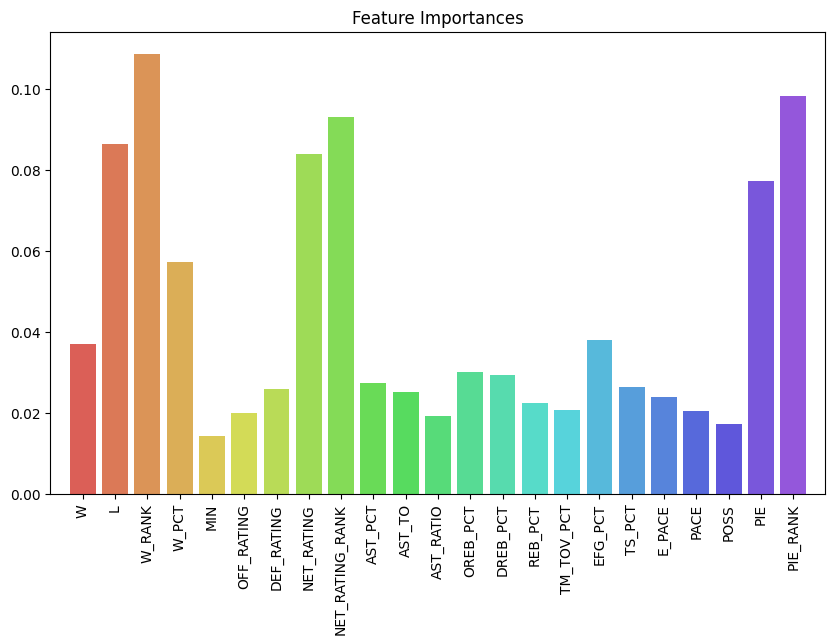

In [390]:
# Get feature importances
importances = rf_scaled.feature_importances_

# Get the feature names
feature_names = X_scaled_train.columns

# Plotting
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X_scaled_train.shape[1]),height=importances, align="center",color=palette)
plt.xticks(range(X_scaled_train.shape[1]), feature_names, rotation=90)
plt.xlim([-1, X_scaled_train.shape[1]])
plt.show()


## Linear Regression Model

In [359]:
lin_mod = LinearRegression()

In [360]:
lin_mod.fit(X_train,y_train)

LinearRegression()

In [361]:
y_lin_reg = lin_mod.predict(X_test)

In [362]:
lin_mod.score(X_test,y_test)

0.4675700921566258

In [363]:
mean_absolute_error(y_test,y_lin_reg)

2.688944001592253

In [364]:
lin_mod.fit(X_scaled_train,y_scaled_train)

LinearRegression()

In [365]:
lin_mod.score(X_scaled_test,y_scaled_test)

0.4675700921565261

## Using Real World Data (Actual NBA Seasons)

In [395]:
# Predicting the number of wins of 2020 season
test_X= merged_df.loc[merged_df['SEASON']==2020]
test_y=test_X[target]
test_X=test_X[features]
scaler.fit(test_X)
test_X_scaled=scaler.transform(test_X)
test_X_df_scaled = pd.DataFrame(data=test_X_scaled,columns=test_X.columns)
test_X_df = pd.DataFrame(data=test_X,columns=test_X.columns) # For curiosity
y_2020 = rf_scaled.predict(test_X_df_scaled)
print(f"R2 score:{r2_score(test_y,y_2020)}\nMAE score:{mean_absolute_error(test_y,y_2020)}")

R2 score:0.6130370971168144
MAE score:1.7233333333333334


In [396]:
idx_2020 = test_X.index
df_2020 = merged_df.iloc[idx_2020]
df_2020['PREDICTED_PLAYOFF_WINS']=np.round(y_2020)
df_2020[['TEAM_NAME','SEASON','W','L','PLAYOFF_WINS','PREDICTED_PLAYOFF_WINS']]

<ipython-input-396-f6d33a8fa26f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['PREDICTED_PLAYOFF_WINS']=np.round(y_2020)


,TEAM_NAME,SEASON,W,L,PLAYOFF_WINS,PREDICTED_PLAYOFF_WINS
479,Atlanta Hawks,2020,20,47,0.0,0.0
480,Boston Celtics,2020,48,24,10.0,10.0
481,Brooklyn Nets,2020,35,37,0.0,2.0
482,Charlotte Hornets,2020,23,42,0.0,0.0
483,Chicago Bulls,2020,22,43,0.0,0.0
484,Cleveland Cavaliers,2020,19,46,0.0,0.0
485,Dallas Mavericks,2020,43,32,2.0,4.0
486,Denver Nuggets,2020,46,27,9.0,4.0
487,Detroit Pistons,2020,20,46,0.0,0.0
488,Golden State Warriors,2020,15,50,0.0,0.0


In [379]:
df_2020.set_index('TEAM_NAME', inplace=True)

<Axes: title={'center': '2020 Season'}, xlabel='TEAM_NAME'>

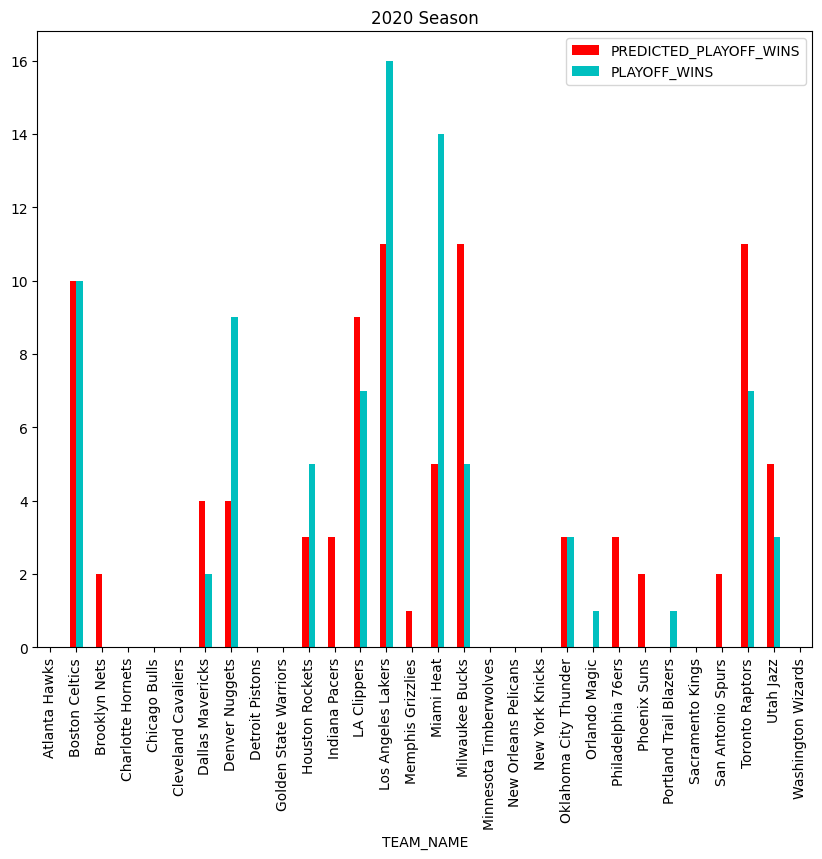

In [392]:
fig,ax = plt.subplots(figsize=(10,8))
df_2020[['PREDICTED_PLAYOFF_WINS','PLAYOFF_WINS']].plot(kind='bar',ax=ax,title='2020 Season',color=['r','c'])

## Predicting 2023 Season sad times :(  

In [381]:
#Predicting number of wins for the 2023 season
test_X= merged_df.loc[merged_df['SEASON']==2023]
test_y=test_X[target]
test_X=test_X[features]
scaler.fit(test_X)
test_X_scaled=scaler.transform(test_X)
test_X_df_scaled = pd.DataFrame(data=test_X_scaled,columns=test_X.columns)
test_X_df = pd.DataFrame(data=test_X,columns=test_X.columns)
y_2023 = rf_scaled.predict(test_X_df_scaled)
print(f"R2 score:{r2_score(test_y,y_2023)}\nMAE score:{mean_absolute_error(test_y,y_2023)}")

R2 score:0.3018793214343143
MAE score:2.3988888888888886


In [382]:
idx_2023 = test_X.index
df_2023 = merged_df.iloc[idx_2023]
df_2023['PREDICTED_PLAYOFF_WINS']=np.round(y_2023)
df_2023.set_index('TEAM_NAME', inplace=True)
df_2023[['SEASON','W','L','W_PCT','PLAYOFF_WINS','PREDICTED_PLAYOFF_WINS']]

<ipython-input-382-4662ca4abb8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['PREDICTED_PLAYOFF_WINS']=np.round(y_2023)


,SEASON,W,L,W_PCT,PLAYOFF_WINS,PREDICTED_PLAYOFF_WINS
TEAM_NAME,,,,,,
Atlanta Hawks,2023,41,41,0.500,2.0,1.0
Boston Celtics,2023,57,25,0.695,11.0,10.0
Brooklyn Nets,2023,45,37,0.549,0.0,2.0
Charlotte Hornets,2023,27,55,0.329,0.0,0.0
Chicago Bulls,2023,40,42,0.488,0.0,3.0
Cleveland Cavaliers,2023,51,31,0.622,1.0,9.0
Dallas Mavericks,2023,38,44,0.463,0.0,1.0
Denver Nuggets,2023,53,29,0.646,16.0,10.0
Detroit Pistons,2023,17,65,0.207,0.0,0.0


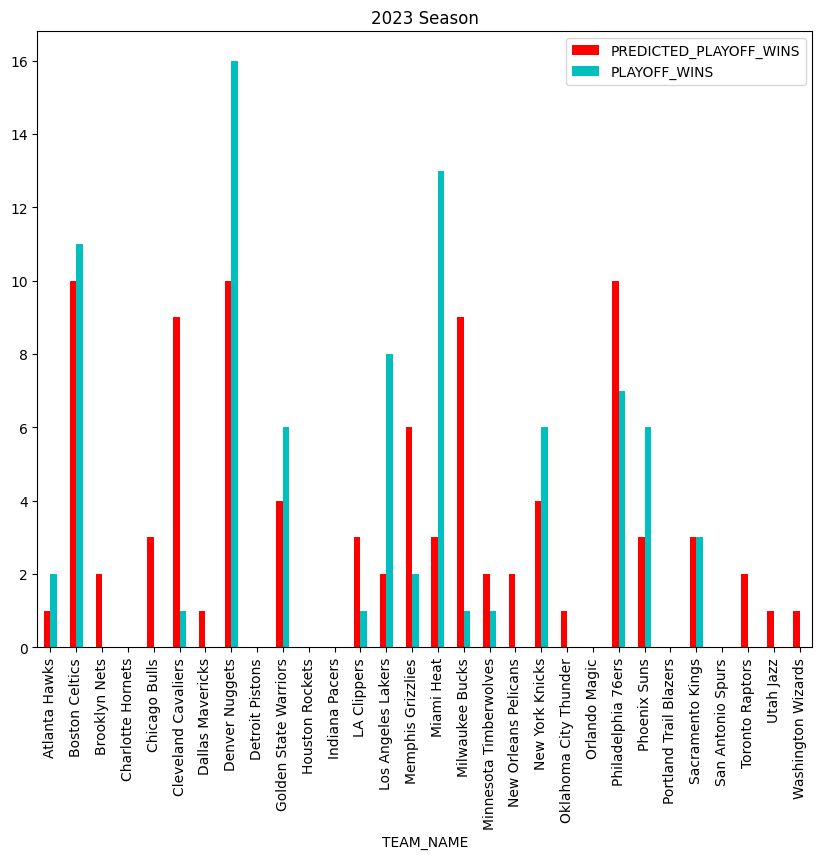

In [393]:
fig,ax = plt.subplots(figsize=(10,8))
df_2023[['PREDICTED_PLAYOFF_WINS','PLAYOFF_WINS']].plot(kind='bar',ax=ax,title='2023 Season',color=['r','c'])
plt.show()

In [373]:
test_X= merged_df.loc[merged_df['SEASON']==2024]
test_y=test_X[target]
test_X=test_X[features]
scaler.fit(test_X)
test_X_scaled=scaler.transform(test_X)
test_X_df_scaled = pd.DataFrame(data=test_X_scaled,columns=test_X.columns)

In [374]:
y_2024 = rf_scaled.predict(test_X_df)

In [375]:
idx_2024 = test_X.index
df_2024 = merged_df.iloc[idx_2024]
df_2024['PREDICTED_PLAYOFF_WINS']=np.round(y_2024)
df_2024[['TEAM_NAME','SEASON','W','L','PLAYOFF_WINS','PREDICTED_PLAYOFF_WINS']]

<ipython-input-375-9a50dd35e0f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['PREDICTED_PLAYOFF_WINS']=np.round(y_2024)


,TEAM_NAME,SEASON,W,L,PLAYOFF_WINS,PREDICTED_PLAYOFF_WINS
599,Atlanta Hawks,2024,9,12,0.0,2.0
600,Boston Celtics,2024,16,5,0.0,3.0
601,Brooklyn Nets,2024,12,9,0.0,3.0
602,Charlotte Hornets,2024,7,13,0.0,2.0
603,Chicago Bulls,2024,9,14,0.0,3.0
604,Cleveland Cavaliers,2024,13,9,0.0,3.0
605,Dallas Mavericks,2024,13,8,0.0,2.0
606,Denver Nuggets,2024,14,9,0.0,3.0
607,Detroit Pistons,2024,2,20,0.0,2.0
608,Golden State Warriors,2024,10,12,0.0,3.0
